In [1]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: /opt/conda/envs/pennylane/bin/python3 -m pip install --upgrade pip


In [2]:
# Coordinates are given in Angstrom
value = 1.3
Beh2 = [["Be", [0.0, 0.0, 0.0]],
        ["H", [-value, 0.0, 0.0]], 
        ["H", [value, 0.0, 0.0]]]
                  
BeH2 = Molecule( # Fill up the function below
    geometry=Beh2 , # ----------- Enter your code here
    multiplicity=1, # ----------- Enter your code here
    charge=0, # ----------- Enter your code here
)

driver = ElectronicStructureMoleculeDriver(BeH2, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [3]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  3
number of beta electrons:  3
number of spin orbitals:  14
nuclear repulsion energy:  3.460004840630769


In [4]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, # Number of electrons in our active space
    num_molecular_orbitals=3, # Number of orbitals in our active space
)

# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [5]:
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
#print(qubit_op)

In [6]:
# Set the mapper to qubits
parity_mapper = ParityMapper() # This is the example of parity mapping

# Set the qubit converter with two qubit reduction to reduce the computational cost 
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)    

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

#print(qubit_op_parity)

In [7]:
vqe_factory = VQEUCCFactory( # This is an example of UCC"SD" ansatz
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(maxiter=6,ftol = 1e-4),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(parity_converter, vqe_factory)  # Define Numpy
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

Reference energy :  (-15.5618501482004+0j)


In [8]:
# Define our 'ansatz' for the problem
ansatz = UCC(
    qubit_converter=parity_converter,
    num_particles=problem_reduced.num_particles, 
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    excitations='sd'
)

In [10]:
from qiskit.primitives import Estimator, BackendEstimator

In [11]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

# Define convergence list
convergence = []

# Keep track of jobs (Do-not-modify)
job_list = []
# Initialize estimator object
estimator = Estimator() # Enter your code here

# Define evaluate_expectation function
def evaluate_expectation(x):
    x = list(x)
    
    # Define estimator run parameters
    #### enter your code below ####
    job = estimator.run(circuits=ansatz, observables=qubit_op_parity,parameter_values=[x]).result() # ----------- Enter your code here
    results = job.values[0]
    job_list.append(job)
    
    # Pass results back to callback function
    return np.real(results)

# Call back function
def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
    convergence.append(evaluate_expectation(fx))

np.random.seed(10)

# Define initial point. We shall define a random point here based on the number of parameters in our ansatz
initial_point = np.random.random(ansatz.num_parameters)

#### enter your code below ####
# Define optimizer and pass callback function
optimizer = SPSA(20, callback=callback) # ----------- Enter your code here

# Define minimize function
result = optimizer.minimize(evaluate_expectation, x0=initial_point) # ----------- Enter your code here


CPU times: user 8.61 s, sys: 71.9 ms, total: 8.69 s
Wall time: 8.73 s


In [12]:
Energy_H_t = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = problem_reduced.interpret(sol).total_energies[0]
    Energy_H_t.append(sol)
print("Computed Energy:", Energy_H_t[-1])

Computed Energy: (-15.538371115104876+0j)


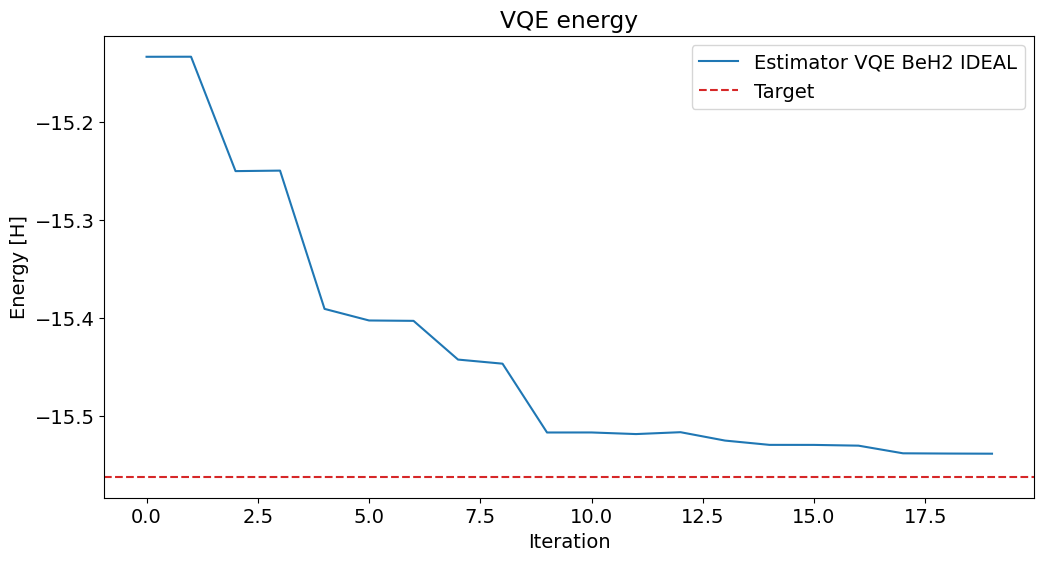

In [13]:
# The following plot compares the two Estimators - with and without noise

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_t, label="Estimator VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [14]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.providers.aer import AerSimulator

In [15]:
def construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo]) # ----------- Enter your code here

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    parity_mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True) # ----------- Enter your code here    

    # Compute the Hamitonian in qubit form
    qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
   
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(maxiter = 50,ftol = 1e-5),ansatz=UCC(excitations='sd')) 
    solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op_parity, real_solution, problem_reduced

In [16]:
# from qiskit.primitives import BaseEstimator
def custom_vqe(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []
    
    # estimator=BaseEstimator()
    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job = estimator.run(circuits=ansatz, observables=ops,parameter_values=[x]).result() # ----------- Enter your code here
        results = job.values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)
        
    # Define minimize function
    result = optimizer.minimize(evaluate_expectation, x0=initial_point) # ----------- Enter your code here

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = MinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

In [17]:
import matplotlib.pyplot as plt

def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.axhline(y=real_solution.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()

In [18]:
algorithm_globals.random_seed = 1024
# For BeH2
ansatz_m, ops_m, real_solution_m, problem_reduced_m = construct_problem(geometry=Beh2, charge=0, multiplicity=1, basis="sto3g", num_electrons=2, num_molecular_orbitals=3)

# Estimator VQE for BeH2
Energy_H_m,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_m, ops=ops_m,problem_reduced=problem_reduced_m)


In [19]:
# Define fake backend
noisy_backend = FakeLagos()

noisy_estimator = BackendEstimator(backend=noisy_backend)

In [20]:
%%time
# Noisy Estimator run
algorithm_globals.random_seed = 1024

Energy_H_m_noisy,_,result = custom_vqe(estimator=noisy_estimator, ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

CPU times: user 2min 52s, sys: 29.4 s, total: 3min 21s
Wall time: 5min 17s


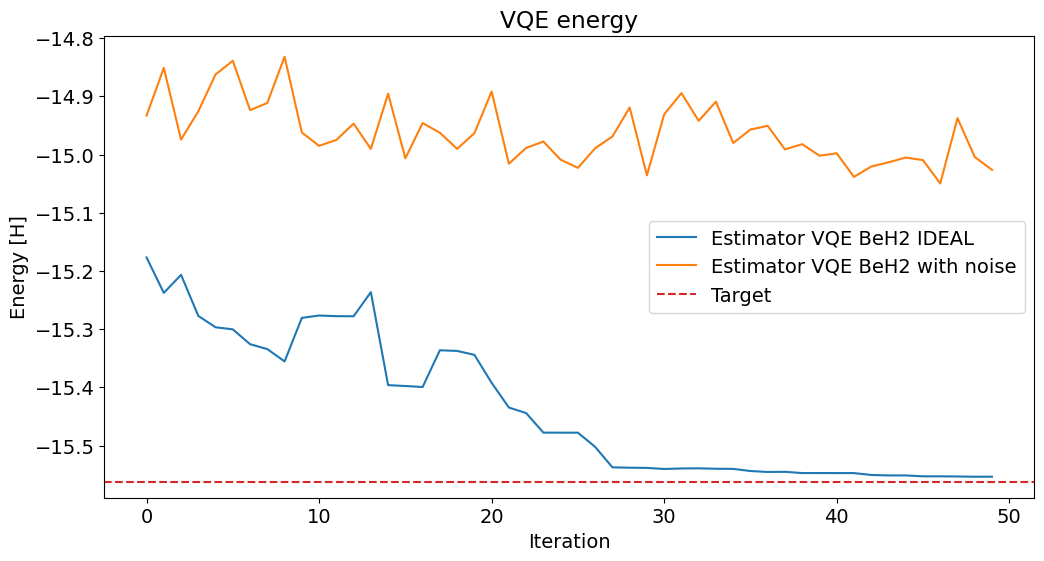

In [21]:
# The following plot compares the two Estimators - with and without noise
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_m, label="Estimator VQE BeH2 IDEAL")
plt.plot(Energy_H_m_noisy, label="Estimator VQE BeH2 with noise")
plt.axhline(y=real_solution_m.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [22]:
from zne import zne

# Define fake backend
noisy_backend = FakeLagos()

# Define Estimator with the fake backend
ZNEEstimator = zne(BackendEstimator)

In [23]:
from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)
# Define Amplifier
noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2) 

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1, 3, 5],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)

In [24]:
# Apply strategy to ZNE Estimator
noisy_estimator_zne = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)

In [25]:
%%time
# Noisy Estimator run
algorithm_globals.random_seed = 1024

Energy_H_m_noisy_zne,_,_ = custom_vqe(estimator=noisy_estimator_zne, ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

CPU times: user 16min 14s, sys: 1min 33s, total: 17min 48s
Wall time: 28min 18s


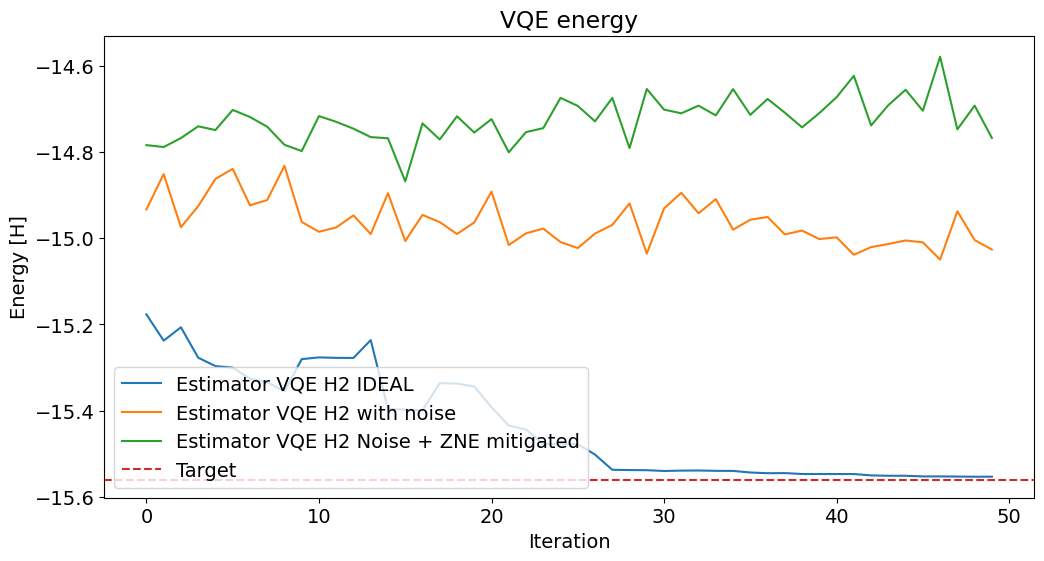

In [26]:

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_m, label="Estimator VQE H2 IDEAL")
plt.plot(Energy_H_m_noisy, label="Estimator VQE H2 with noise")
plt.plot(Energy_H_m_noisy_zne, label="Estimator VQE H2 Noise + ZNE mitigated")
plt.axhline(y=real_solution_m.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()